In [3]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import xclimate as xclim

In [4]:
variables = [
    "TSA_month_1",
    "EFLX_LH_TOT_month_1",
    "FCTR_month_1",
    "TLAI_month_1",
    "SOILWATER_10CM_month_1",
    "FSDS_month_1", "FSR_month_1", "FLDS_month_1", "FIRE_month_1",  # for net radiation
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

  TSA_month_1
  EFLX_LH_TOT_month_1
  FCTR_month_1
  TLAI_month_1
  SOILWATER_10CM_month_1
  FSDS_month_1
  FSR_month_1
  FLDS_month_1
  FIRE_month_1


In [10]:
# Monthly net radiation at the surface, + down
#   Rn = (net SW) + (net LW) = (down SW - up SW) - (down LW - up LW)
#   Rn = FSDS - FSR + FLDS - FIRE
print("  RN_month_1")
if "RN_month_1" not in fhist.keys():
    fhist["RN_month_1"] = fhist["FSDS_month_1"] - fhist["FSR_month_1"] + fhist["FLDS_month_1"] - fhist["FIRE_month_1"]
    fhist["RN_month_1"] = fhist["RN_month_1"].rename("RN")
    fhist["RN_month_1"].attrs = {
        "long_name": "net radiation at surface [+ down]",
        "description": "FSDS - FSR + FLDS - FIRE",
        "units": "W/m2",
    }

try:
    fhist.pop("FSDS_month_1")
    fhist.pop("FSR_month_1")
    fhist.pop("FLDS_month_1")
    fhist.pop("FIRE_month_1")
except KeyError:
    print("  already removed")

  RN_month_1
  already removed


In [28]:
for v in list(fhist.keys()):
    if "month" in v:
        name = "_".join(v.split("_")[:-2])
        print(f"{name}_year_1")
        fhist[f"{name}_year_1"] = fhist[f"{name}_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time")).compute()

TSA_year_1
EFLX_LH_TOT_year_1
FCTR_year_1
TLAI_year_1
SOILWATER_10CM_year_1
RN_year_1


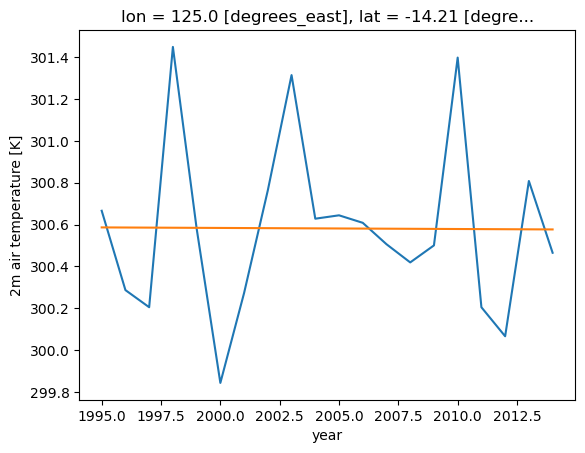

In [39]:
fhist["TSA_year_1"].isel(lat=40, lon=50, member=0).plot()

year = fhist["TSA_year_1"].year.values
plt.plot(year, da_tuple[1].item() + year * da_tuple[0].item())

In [33]:
da_tuple = xclim.regression.ols_field(
    fhist["TSA_year_1"].isel(lat=40, lon=50, member=0).year,  fhist["TSA_year_1"].isel(lat=40, lon=50, member=0), sample_dim="year"
)

In [45]:
da_tuple = xclim.regression.ols_field(
    fhist["TSA_year_1"].year,  fhist["TSA_year_1"], sample_dim="year"
)

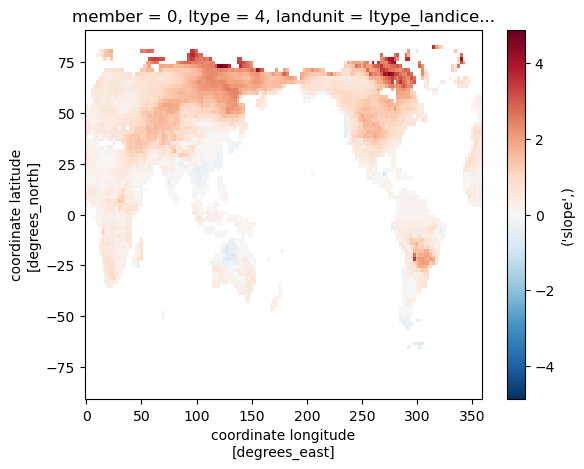

In [ ]:
y = fhist["TSA_year_1"].isel(lat=40, lon=50, member=0)
x = fhist["TSA_year_1"].year.values


y.plot()


trend = 
plt.plot(year, da_tuple[1].item() + year * da_tuple[0].item())